In [122]:
from __future__ import annotations

import json
from pathlib import Path
from typing import Any, Dict, List, Sequence, Tuple, Optional

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', None)

# File-loading helper

In [123]:
def load_sessions(path: str | Path, *, key: Optional[str] = None) -> List[List[dict]]:
    """
    Read a JSON-Lines file into a list of line-chunks (list[list[dict]]).
    Each line is either a plain list or an object holding the list under *key*.
    Strips any 'priority' keys to keep evaluation agnostic.
    """
    def _strip(v: Any) -> Any:
        if isinstance(v, dict) and 'priority' in v:
            v = {k: _strip(vv) for k, vv in v.items() if k != 'priority'}
        elif isinstance(v, list):
            v = [_strip(i) for i in v]
        return v

    chunks = []
    with Path(path).expanduser().open() as f:
        for line in f:
            obj   = json.loads(line)
            chunk = obj[key] if (key and key in obj) else obj
            chunks.append([_strip(d) for d in chunk])
    return chunks

# Flatten-Jaccard utilities

In [124]:
def _to_set(d: Dict, *, _prefix: Tuple[str, ...] = ()) -> frozenset:
    items = []
    for k, v in d.items():
        new_prefix = _prefix + (k,)
        if isinstance(v, dict):
            items.extend(_to_set(v, _prefix=new_prefix))
        elif isinstance(v, list):
            items.append((new_prefix, tuple(v)))
        else:
            items.append((new_prefix, v))
    return frozenset(items)

def jaccard(a: Dict, b: Dict) -> float:
    s1, s2 = _to_set(a), _to_set(b)
    return len(s1 & s2) / len(s1 | s2) if s1 | s2 else 1.0

# Metric configuration

In [125]:
# numeric action fields to score with MAE
NUMERIC_FIELDS = [
    ('tv',       'volume'),
    ('tv',       'brightness'),
    ('ac',       'temperature'),
    ('lights',   'brightness'),
    ('speaker',  'volume'),
    ('security', 'alarm_volume'),
]

# discrete trigger & action classes for exact accuracy
DISCRETE_FIELDS = [
    ('triggers', 'time_of_day'),
    ('triggers', 'day_of_week'),
    ('triggers', 'sun_phase'),
    ('triggers', 'weather'),
    ('triggers', 'outdoor_temp'),
    ('actions',  'tv',      'input_source'),
    ('actions',  'ac',      'mode'),
    ('actions',  'ac',      'fan_speed'),
    ('actions',  'lights',  'color'),
    ('actions',  'lights',  'mode'),
    ('actions',  'speaker', 'equalizer'),
    ('actions',  'security','armed'),
]

_fmt_glob = {
    'exact_routines': 'acc.routine_exact',
    'exact_triggers': 'acc.triggers_exact',
    'exact_actions' : 'acc.actions_exact',
    'jac_routines'  : 'jaccard.flattened',
    'avg_len_diff'  : 'Δlen.avg',
}

_fmt_disc = lambda path: f"acc.{'.'.join(path)}"
_fmt_mae  = lambda cat, fld: f"mae.{cat}.{fld}"

# Core evaluator

In [126]:
def _dig(mapping: dict, path: Tuple[str, ...]) -> Any:
    """Traverse nested dict; return None if path missing."""
    for key in path:
        if not isinstance(mapping, dict):
            return None
        mapping = mapping.get(key)
    return mapping

def evaluate_all(gt: Sequence[Sequence[dict]],
                 preds: Sequence[Sequence[dict]]) -> pd.Series:
    """
    Return a Series containing:
    • global exact accuracies & Jaccard
    • per-field discrete accuracies
    • per-field numeric MAEs
    """
    assert len(gt) == len(preds), "GT/pred chunks mis-aligned"

    n_gt_routines = 0
    exact_routines = exact_triggers = exact_actions = jac_sum = 0.0
    len_diff_sum = 0

    discrete_tot = {p: 0 for p in DISCRETE_FIELDS}
    discrete_eq  = {p: 0 for p in DISCRETE_FIELDS}
    mae_buf      = {f"{c}_{f}_mae": [] for c, f in NUMERIC_FIELDS}

    for gts, prs in zip(gt, preds):
        len_diff_sum += abs(len(gts) - len(prs))
        n_gt_routines += len(gts)

        def _best_match(g):
            return max(prs, key=lambda p: jaccard(g, p), default=None)

        for g in gts:
            p = _best_match(g)
            if p is None:
                continue

            # global scores
            exact_routines += int(g['triggers'] == p['triggers'] and g['actions'] == p['actions'])
            exact_triggers += int(g['triggers'] == p['triggers'])
            exact_actions  += int(g['actions']  == p['actions'])
            jac_sum        += jaccard(g, p)

            # discrete-field accuracy
            for path in DISCRETE_FIELDS:
                gt_val = _dig(g, path)
                pr_val = _dig(p, path)
                if gt_val is not None:
                    discrete_tot[path] += 1
                    discrete_eq[path]  += int(gt_val == pr_val)

            # numeric MAE
            ga, pa = g.get('actions', {}), p.get('actions', {})
            for cat, fld in NUMERIC_FIELDS:
                gcat = ga.get(cat); pcat = pa.get(cat)
                gval = gcat.get(fld) if isinstance(gcat, dict) else None
                pval = pcat.get(fld) if isinstance(pcat, dict) else None
                if isinstance(gval, (int, float)) and isinstance(pval, (int, float)):
                    mae_buf[f"{cat}_{fld}_mae"].append(abs(gval - pval))

    n_gt = max(n_gt_routines, 1)
    global_metrics = {
        _fmt_glob[k]: v for k, v in {
            'exact_routines': exact_routines / n_gt,
            'exact_triggers': exact_triggers / n_gt,
            'exact_actions' : exact_actions  / n_gt,
            'jac_routines'  : jac_sum        / n_gt,
            'avg_len_diff'  : len_diff_sum   / len(gt),
        }.items()
    }

    disc_metrics = {
        _fmt_disc(path): (discrete_eq[path] / discrete_tot[path] if discrete_tot[path] else np.nan)
        for path in DISCRETE_FIELDS
    }

    mae_metrics = {
        _fmt_mae(*k.split('_')[0:2]): (np.mean(v) if v else np.nan)
        for k, v in mae_buf.items()          # k format: "tv_volume_mae"
    }

    return pd.Series({**global_metrics, **disc_metrics, **mae_metrics})

# Evaluate models

In [127]:
RENAME = {
    'deepseek': 'DeepSeek-V3',
    'gpt':      'GPT-4o',
    'gemini':   'Gemini-2.5-Flash',
    'qwen':     'Qwen2.5-3B',
    'llama':    'Llama-3.2-3B',
    'phi4':     'Phi-4-mini-4B',
    'gemma3':   'Gemma-3-4B',
}

ORDER = ['DeepSeek-V3','GPT-4o','Gemini-2.5-Flash','Gemma-3-4B', 'Qwen2.5-3B','Llama-3.2-3B','Phi-4-mini-4B']

In [128]:
def evaluate_many(gt_file: str | Path,
                  pred_glob: str | Path,
                  *, key: str = 'routines') -> pd.DataFrame:
    gt = load_sessions(gt_file, key=key)
    rows = []
    for p in sorted(Path('.').glob(str(pred_glob))):
        rows.append(evaluate_all(gt, load_sessions(p)).rename(RENAME[p.stem.split('_')[-1]]))
    return pd.DataFrame(rows).loc[ORDER]

# Run evaluation

In [129]:
GT_PATH   = "../../../generated_data/routines_final.jsonl"
PRED_GLOB = "../../../outputs/exact_predictions_*.jsonl"

In [130]:
leaderboard = evaluate_many(GT_PATH, PRED_GLOB)
leaderboard

,acc.routine_exact,acc.triggers_exact,acc.actions_exact,jaccard.flattened,Δlen.avg,acc.triggers.time_of_day,acc.triggers.day_of_week,acc.triggers.sun_phase,acc.triggers.weather,acc.triggers.outdoor_temp,acc.actions.tv.input_source,acc.actions.ac.mode,acc.actions.ac.fan_speed,acc.actions.lights.color,acc.actions.lights.mode,acc.actions.speaker.equalizer,acc.actions.security.armed,mae.tv.volume,mae.tv.brightness,mae.ac.temperature,mae.lights.brightness,mae.speaker.volume,mae.security.alarm
DeepSeek-V3,0.268507,0.584693,0.318695,0.818638,0.005,0.988708,0.651015,0.606784,0.973618,0.977387,0.960133,0.989181,0.982998,0.992157,0.946405,0.913349,0.880814,0.086505,0.138408,0.029595,0.340314,0.063613,0.119454
GPT-4o,0.350063,0.983689,0.356336,0.854479,0.005,0.997491,0.998731,1.000000,0.996231,0.998744,0.983389,0.993818,0.992272,1.000000,0.900654,0.978923,0.936047,0.016949,0.016949,0.000000,0.052288,0.000000,0.000000
Gemini-2.5-Flash,0.439147,0.943538,0.454203,0.895504,0.000,0.997491,0.993655,0.976131,0.974874,0.994975,0.983389,0.992272,0.986090,0.992157,0.661438,0.936768,0.877907,0.016949,0.034130,0.007764,0.026316,0.024691,0.000000
Gemma-3-4B,0.022585,0.528231,0.035132,0.662078,0.060,0.914680,0.951777,0.585427,0.587940,0.551508,0.847176,0.947450,0.941267,0.946405,0.652288,0.936768,0.872093,1.171875,1.969697,0.157729,1.679790,0.266344,1.050336
Qwen2.5-3B,0.007528,0.772898,0.010038,0.554315,0.265,0.791719,0.898477,0.871859,0.805276,0.814070,0.279070,0.761978,0.751159,0.788235,0.585621,0.501171,0.255814,1.435644,1.702128,0.421875,4.866947,1.354582,1.242105
Llama-3.2-3B,0.011292,0.767880,0.011292,0.399191,0.045,0.881463,0.940051,0.950758,0.864899,0.834596,0.146667,0.267081,0.257764,0.257218,0.248031,0.263529,0.195906,2.244898,1.555556,0.258242,3.772727,0.702479,2.837838
Phi-4-mini-4B,0.000000,0.023839,0.000000,0.231023,0.845,0.637908,0.650794,0.087696,0.074607,0.041885,0.231034,0.272000,0.419200,0.608696,0.131793,0.410194,0.178248,6.250000,5.833333,1.327119,13.399453,5.661017,11.616438


# Plot metrics on whole routines

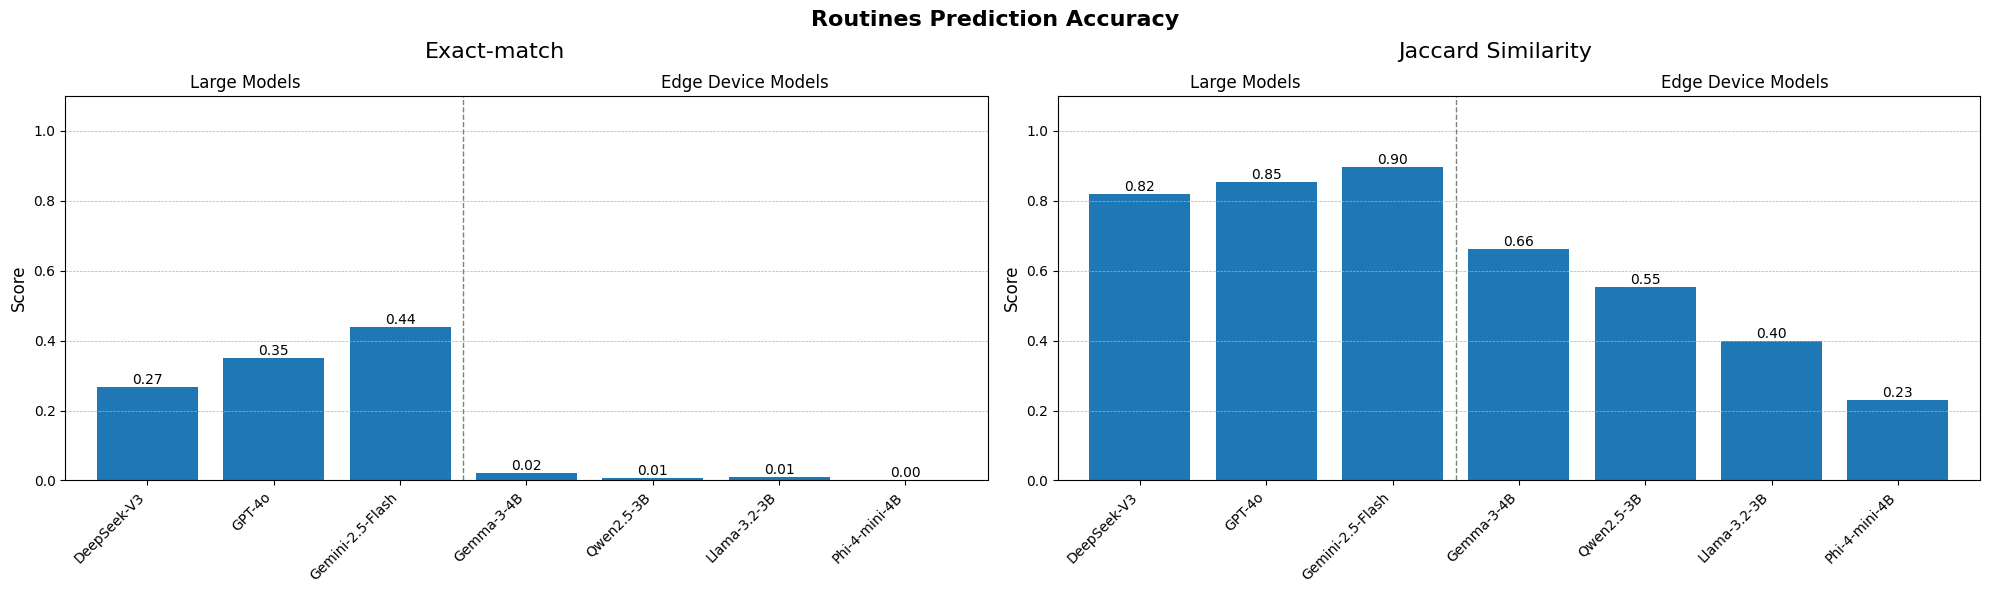

In [131]:
def plot_with_subgroups(df, col, ax, sep=2.5):
    df[col].plot(kind='bar', ax=ax, width=0.8)
    ax.set_ylim(0,1.1)
    ax.set_ylabel('Score', fontsize=12)
    ax.set_xticklabels(df.index, rotation=45, ha='right')
    ax.grid(axis='y', linestyle='--', linewidth=0.5)
    ax.axvline(x=sep, linestyle='--', linewidth=1, color='gray')
    for p in ax.patches:
        ax.annotate(f'{p.get_height():.2f}',
                    (p.get_x()+p.get_width()/2, p.get_height()),
                    ha='center', va='bottom', fontsize=10)

fig, (ax1, ax2) = plt.subplots(1,2, figsize=(20,6))
plot_with_subgroups(leaderboard, 'acc.routine_exact', ax1, sep=2.5)
plot_with_subgroups(leaderboard, 'jaccard.flattened',   ax2, sep=2.5)

# subgroup labels for routines plot
fig.text(0.250, 0.90, 'Exact-match', ha='center', fontsize=16)
fig.text(0.125, 0.85, 'Large Models', ha='center', fontsize=12)
fig.text(0.375, 0.85, 'Edge Device Models', ha='center', fontsize=12)

# subgroup labels for jaccard plot
fig.text(0.750, 0.90, 'Jaccard Similarity', ha='center', fontsize=16)
fig.text(0.625, 0.85, 'Large Models', ha='center', fontsize=12)
fig.text(0.875, 0.85, 'Edge Device Models', ha='center', fontsize=12)

fig.suptitle('Routines Prediction Accuracy', fontsize=16, fontweight='bold')
plt.tight_layout(rect=[0,0,1,0.92])
plt.show()

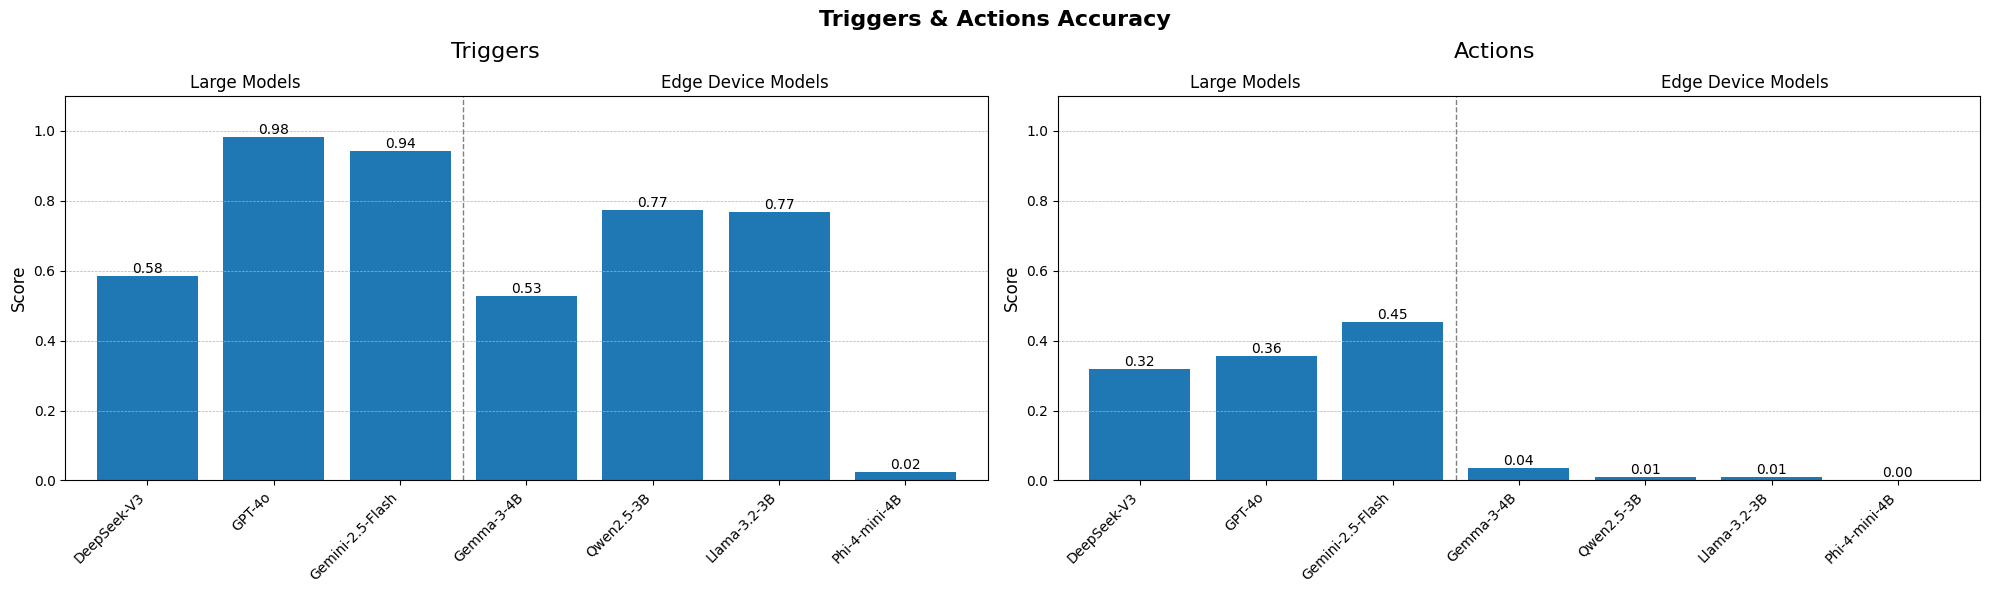

In [132]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(20,6))
plot_with_subgroups(leaderboard, 'acc.triggers_exact', ax1, sep=2.5)
plot_with_subgroups(leaderboard, 'acc.actions_exact',  ax2, sep=2.5)

# subgroup labels for triggers plot
fig.text(0.250, 0.90, 'Triggers', ha='center', fontsize=16)
fig.text(0.125, 0.85, 'Large Models', ha='center', fontsize=12)
fig.text(0.375, 0.85, 'Edge Device Models', ha='center', fontsize=12)

# subgroup labels for actions plot
fig.text(0.750, 0.90, 'Actions', ha='center', fontsize=16)
fig.text(0.625, 0.85, 'Large Models', ha='center', fontsize=12)
fig.text(0.875, 0.85, 'Edge Device Models', ha='center', fontsize=12)

fig.suptitle('Triggers & Actions Accuracy', fontsize=16, fontweight='bold')
plt.tight_layout(rect=[0,0,1,0.92])
plt.show()